In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model #GARCH Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import math
from statistics import NormalDist
from scipy.stats import t
from datetime import datetime
from scipy.stats import shapiro #Shapiro Test
from scipy import stats #t-test
import statsmodels.api as sm #Ljung-Box Test
from scipy.stats import chi2


start_date = '2006-01-01' #yyyy-mm-dd
end_date = '2021-01-01'


#Philippines
PH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/PSEi.csv')
PH['Date'] = pd.to_datetime(PH['Date'])
PH = PH.rename(columns={'Price': 'Close'})
PH = PH.replace(',','', regex=True)
PH['Close'] = PH['Close'].astype(float, errors = 'raise')
mask = (PH['Date'] >= start_date) & (PH['Date'] <= end_date)
PH = PH.loc[mask]
PH = PH.set_index('Date')
PH = PH.sort_index(axis=0, ascending = False)
#Malaysia
MY = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/%5EKLSE.csv')
MY['Date'] = pd.to_datetime(MY['Date'])
MY = MY.rename(columns={'Price': 'Close'})
MY = MY.replace(',','', regex=True)
MY['Close'] = MY['Close'].astype(float, errors = 'raise')
mask = (MY['Date'] >= start_date) & (MY['Date'] <= end_date)
MY = MY.loc[mask]
MY = MY.set_index('Date')
MY = MY.sort_index(axis=0, ascending = False).dropna()

#Signapore
SG = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/STI.csv')
SG['Date'] = pd.to_datetime(SG['Date'])
SG = SG.replace(',','', regex=True)
SG['Close'] = SG['Close'].astype(float, errors = 'raise')
mask = (SG['Date'] >= start_date) & (SG['Date'] <= end_date)
SG = SG.loc[mask]
SG= SG.set_index('Date')
SG = SG.sort_index(axis=0, ascending = False).dropna()

#Thailand
TH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/SETi.csv')
TH['Date'] = pd.to_datetime(TH['Date'])
TH = TH.rename(columns={'Price': 'Close'})
TH = TH.replace(',','', regex=True)
TH['Close'] = TH['Close'].astype(float, errors = 'raise')
mask = (TH['Date'] >= start_date) & (TH['Date'] <= end_date)
TH = TH.loc[mask]
TH= TH.set_index('Date')
TH = TH.sort_index(axis=0, ascending = False).dropna()

#Vietnam
VT = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/HNX.csv')
VT['Date'] = pd.to_datetime(VT['Date'])
VT = VT.rename(columns={'Price': 'Close'})
VT = VT.replace(',','', regex=True)
VT['Close'] = VT['Close'].astype(float, errors = 'raise')
mask = (VT['Date'] >= start_date) & (VT['Date'] <= end_date)
VT = VT.loc[mask]
VT= VT.set_index('Date')
VT = VT.sort_index(axis=0, ascending = False).dropna()

def get_returns(df,d):
    df['Previous'] = df['Close'].shift(-d)
    df['Returns'] = np.log(df['Close']/df['Previous'])*100
    return df.dropna(subset =['Returns'], how = 'all')

PH = get_returns(PH, 1)
MY = get_returns(MY, 1)
SG = get_returns(SG, 1)
TH = get_returns(TH, 1)
VT = get_returns(VT, 1)

In [33]:
def get_VaR_IGARCH(df, alpha, sigma, dist):
    if dist == 'normal':
        VaR = sigma*NormalDist().inv_cdf(1-alpha) #t.ppf(1-alpha, len(df['Returns'])-1 )
    elif dist == 't':
        VaR = sigma*t.ppf(1-alpha, len(df['Returns'])-1 )
    return VaR

def fit_params(df, vol,  p = None, q = None):
    returns = df['Returns']
    model = arch_model(returns, vol = vol, p = p, q = q, rescale = False)
    fit = model.fit(disp = 'off')
    params = fit.params
    resid = fit.resid
    condv = fit.conditional_volatility
    return fit, params, resid, condv

def fixed_window(df, vol, h, prediction_size, alpha, dist, p= None, q = None , d = None):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[i:-(test_size-i)]
        model = arch_model(temp_df, vol = vol, p = p, q = q, rescale = None)
        fit = model.fit(disp = 'off')
        params = fit.params
        if d != None:
            params_adj = np.zeros([1,len(params)])
            for j in range(0,len(params)):
                if j == 2+p:
                    params_adj[0,2+p] = d
                else:
                    params_adj[0,j] = params[j]
        model_adj = model.fix(params_adj)
        pred = model_adj.forecast(horizon=h, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_IGARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df

def rolling_window(df, vol, h, prediction_size, alpha, dist, p= None, q = None , d = None):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[:-(test_size-i)]
        model = arch_model(temp_df, p=p, q=q, vol = vol , rescale=None)
        fit = model.fit(disp='off')
        params = fit.params
        if d != None:
            params_adj = np.zeros([1,len(params)])
            for j in range(0,len(params)):
                if j == 2+p:
                    params_adj[0,2+p] = d
                else:
                    params_adj[0,j] = params[j]
        model_adj = model.fix(params_adj)
        pred = model_adj.forecast(horizon=h, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_IGARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df

def char_function(df, window, prediction_size, name):
    test_size = no_to_test(df, prediction_size)
    returns = df['Returns'][:test_size]
    f_returns = window.values
    N = 0
    violation_lst = []
    for i, j in zip(returns, f_returns):
        if i < -j :
            violation_lst.append(1)
            N += 1 
        else:
            violation_lst.append(0)
    violations = pd.Series(violation_lst, index = returns.index, name = name)
    df = df.join(violations)
    return df, N


def no_to_test(df, prediction_size):
    return int(np.ceil(len(df)*prediction_size))

In [32]:
def fixed_window(df, vol, h, prediction_size, alpha, dist, p= None, q = None , d = None):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[i:-(test_size-i)]
        model = arch_model(temp_df, vol = vol, p = p, q = q, rescale = None)
        fit = model.fit(disp = 'off')
        params = fit.params
        if d != None:
            params_adj = np.zeros([1,len(params)])
            for i in range(0,len(params)):
                if i == 2+p:
                    params_adj[0,2+p] = d
                else:
                    params_adj[0,i] = params[i]
        model_adj = model.fix(params_adj)
        pred = model_adj.forecast(horizon=h, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    display(sigma_df)
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_IGARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df

test_size = 2
sigma_df = np.zeros((test_size, 1))
returns = PH['Returns']
for i in range(test_size):
        temp_df = returns[i:-(test_size-i)]
        model = arch_model(temp_df, vol = 'figarch', p = 1, q = 1, rescale = None)
        fit = model.fit(disp = 'off')
        params = fit.params
        if d != None:
            params_adj = np.zeros([1,len(params)])
            for j in range(0,len(params)):
                if j == 2+p:
                    params_adj[0,2+p] = 1
                else:
                    params_adj[0,j] = params[j]
        model_adj = model.fix(params_adj)
        pred = model_adj.forecast(horizon=h, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
sigma_df

array([[2.46390358],
       [2.1709588 ]])

In [7]:
prediction_size = 0.1
alpha = 0.05
vol = 'figarch'
d = 0.6333
h = 1
dist = 'normal'
p = 1
q = 1
name = 'FW-I-5%'

In [3]:
PH_fit_i, PH_params_i, PH_resid_i, PH_condv_i = fit_params(PH, vol, p, q)
MY_fit_i, MY_params_i, MY_resid_i, MY_condv_i = fit_params(MY, vol, p, q)
SG_fit_i, SG_params_i, SG_resid_i, SG_condv_i = fit_params(SG, vol, p, q)
TH_fit_i, TH_params_i, TH_resid_i, TH_condv_i = fit_params(TH, vol, p, q)
VT_fit_i, VT_params_i, VT_resid_i, VT_condv_i = fit_params(VT, vol, p, q)

NameError: name 'fit_params' is not defined

In [87]:
#Philippines
print(sm.stats.acorr_ljungbox((PH_resid_i**2).dropna(), lags=[20], return_df=True))

#Malaysia
print(sm.stats.acorr_ljungbox((MY_resid_i**2).dropna(), lags=[20], return_df=True))

#Singapore
print(sm.stats.acorr_ljungbox((SG_resid_i**2).dropna(), lags=[20], return_df=True))

#Thailand
print(sm.stats.acorr_ljungbox((TH_resid_i**2).dropna(), lags=[20], return_df=True))

#Vietnam
print(sm.stats.acorr_ljungbox((VT_resid_i**2).dropna(), lags=[20], return_df=True))

       lb_stat     lb_pvalue
20  364.071062  5.578375e-65
       lb_stat     lb_pvalue
20  443.485159  1.858700e-81
        lb_stat      lb_pvalue
20  1056.601741  3.276905e-211
       lb_stat     lb_pvalue
20  489.100062  5.559454e-91
       lb_stat     lb_pvalue
20  162.701577  2.256779e-24


In [34]:
PH_sigma_df_i, PH_fw_df_i = fixed_window(PH, vol, h, prediction_size, alpha, dist, p = 1, q = 1 , d = d)
MY_sigma_df_i, MY_fw_df_i = fixed_window(MY, vol, h, prediction_size, alpha, dist, p = 1, q = 1 , d = d)
SG_sigma_df_i, SG_fw_df_i = fixed_window(SG, vol, h, prediction_size, alpha, dist, p = 1, q = 1 , d = d)
TH_sigma_df_i, TH_fw_df_i = fixed_window(TH, vol, h, prediction_size, alpha, dist, p = 1, q = 1 , d = d)
VT_sigma_df_i, VT_fw_df_i = fixed_window(VT, vol, h, prediction_size, alpha, dist, p = 1, q = 1 , d = d)

array([[1.40498348],
       [1.54307814],
       [1.08610053],
       [1.96330681],
       [1.25451152],
       [1.09105507],
       [1.12481342],
       [0.79145175],
       [1.33881094],
       [0.83269183],
       [0.75834544],
       [0.6217797 ],
       [2.02861357],
       [2.00477294],
       [1.45471751],
       [1.27132124],
       [0.87514155],
       [1.19554967],
       [0.85894504],
       [0.70591459],
       [2.10985387],
       [1.37883084],
       [1.02452528],
       [0.90402976],
       [3.17740318],
       [1.70529628],
       [1.40725779],
       [1.34711695],
       [1.17649368],
       [1.41635375],
       [0.85378499],
       [0.85289589],
       [1.54151189],
       [0.85477533],
       [0.65479695],
       [1.30446842],
       [1.74370333],
       [1.05698511],
       [1.15756555],
       [0.72535822],
       [0.66360988],
       [0.53351357],
       [0.71616628],
       [1.33463457],
       [1.14619042],
       [0.85427291],
       [0.62832545],
       [2.226

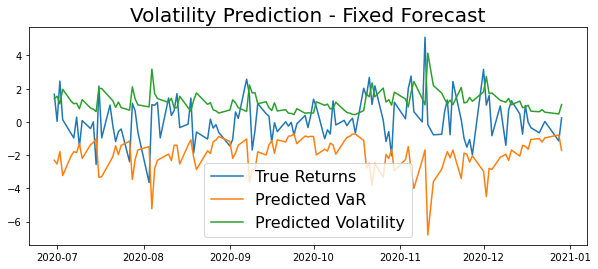

In [36]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_fw_df_i)
plt.plot(PH_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_fw_df_i)
plt.plot(MY_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_fw_df_i)
plt.plot(SG_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_fw_df_i)
plt.plot(TH_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_fw_df_i)
plt.plot(VT_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

In [ ]:
PH, PH_N_fw_i = char_function(PH, PH_fw_df_i, prediction_size, name)
MY, MY_N_fw_i = char_function(MY, MY_fw_df_i, prediction_size, name)
SG, SG_N_fw_i = char_function(SG, SG_fw_df_i, prediction_size, name)
TH, TH_N_fw_i = char_function(TH, TH_fw_df_i, prediction_size, name)
VT, VT_N_fw_i = char_function(VT, VT_fw_df_i, prediction_size, name)

In [ ]:
prediction_size = 0.1
alpha = 0.05
vol = 'figarch'
d = 0.6333
h = 1
dist = 'normal'
p = 1
q = 1
name = 'RW-I-5%'

In [ ]:
PH_sigma_df_i, PH_rw_df_i = rolling_window(PH, prediction_size,d, alpha,p,q, vol, dist)
MY_sigma_df_i, MY_rw_df_i = rolling_window(MY, prediction_size,d, alpha,p,q, vol, dist)
SG_sigma_df_i, SG_rw_df_i = rolling_window(SG, prediction_size,d, alpha,p,q, vol, dist)
TH_sigma_df_i, TH_rw_df_i = rolling_window(TH, prediction_size,d, alpha,p,q, vol, dist)
VT_sigma_df_i, VT_rw_df_i = rolling_window(VT, prediction_size,d, alpha,p,q, vol, dist)


In [ ]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_rw_df_i)
plt.plot(PH_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_rw_df_i)
plt.plot(MY_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_rw_df_i)
plt.plot(SG_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_rw_df_i)
plt.plot(TH_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_rw_df_i)
plt.plot(VT_sigma_df_i)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16i

In [ ]:
#Philippines
PH, PH_N_rw_i = char_function(PH, PH_rw_df_i, prediction_size, name)

#Malaysia
MY, MY_N_rw_i = char_function(MY, MY_rw_df_i, prediction_size, name)

#Singapore
SG, SG_N_rw_i = char_function(SG, SG_rw_df_i, prediction_size, name)
    
#Thailand
TH, TH_N_rw_i = char_function(TH, TH_rw_df_i, prediction_size, name)

#Vietnam
VT, VT_N_rw_i = char_function(VT, VT_rw_df_i, prediction_size, name)

In [ ]:
def CI_UC(alpha, ss):
    CI = []
    a = np.ceil(alpha*ss - (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    b = np.ceil(alpha*ss + (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    CI.append(a)
    CI.append(b)
    return CI


print(CI_UC(alpha,test_size))


In [ ]:
print(chi2.ppf(1-alpha, df = 1))
print(chi2.ppf(1-alpha, df = 2))

In [ ]:
alpha = 0.05
entries1 = no_to_test(PH, prediction_size)
entries2 = no_to_test(MY, prediction_size)
entries3 = no_to_test(SG, prediction_size)
entries4 = no_to_test(TH, prediction_size)
entries5 = no_to_test(VT, prediction_size)
name_1 = 'FW-I-5%'
name_2 = 'RW-I-5%'

In [ ]:
def LR_kupiec(N, observations, alpha):
    p = alpha
    return -2*np.log((((1-p)**(observations - N))*(p**N))/(((1-N/observations)**(observations - N))*((N/observations)**N)))



#Philippines
PH_LRk_fw_i = LR_kupiec(PH_N_fw_i,entries1, alpha)
PH_LRk_rw_i = LR_kupiec(PH_N_rw_i,entries1, alpha)

#Malaysia
MY_LRk_fw_i = LR_kupiec(MY_N_fw_i, entries2, alpha)
MY_LRk_rw_i = LR_kupiec(MY_N_rw_i, entries2, alpha)

#Singapore
SG_LRk_fw_i = LR_kupiec(SG_N_fw_i, entries3, alpha)
SG_LRk_rw_i = LR_kupiec(SG_N_rw_i, entries3, alpha)

#Thailand
TH_LRk_fw_i = LR_kupiec(TH_N_fw_i, entries4, alpha)
TH_LRk_rw_i = LR_kupiec(TH_N_rw_i, entries4, alpha)

#Vietnam
VT_LRk_fw_i = LR_kupiec(VT_N_fw_i, entries5, alpha)
VT_LRk_rw_i = LR_kupiec(VT_N_rw_i, entries5, alpha)

In [ ]:
def no_of_periods(df, name):
    n00 = 0
    n01 = 0
    n10 = 0
    n11 = 0
    violations = df[name].dropna()[::-1]
    v_p = violations[0]
    i = 1
    while i < len(violations):
        if v_p == violations[i] and v_p == 0:
            n00 += 1
        elif v_p != violations[i] and v_p == 0:
            n01 += 1
        elif v_p != violations[i] and v_p == 1:
            n10 += 1
        else:
            n11 += 1
        v_p = violations[i]
        i += 1 
    return n00, n01, n10, n11

In [ ]:
def LR_ind(df, name, LR_pof):
    n00, n01, n10, n11 = no_of_periods(df, name)
    pi_0 = n01/(n00+n01)
    pi_1 = n11/(n10+n11)
    pi = (n01+n11)/(n00+n01+n10+n11)
    LR_ind = -2*np.log((((1-pi)**(n00+n01))*(pi**(n01+n11)))/(((1-pi_0)**n00)*(pi_0**n01)*((1-pi_1)**n10)*(pi_1**n11)))
    LR_cc = LR_ind+LR_pof
    display(LR_cc)
    return LR_ind, LR_cc

#Philippines
PH_LRcci_fw_i, PH_LRcc_fw_i = LR_ind(PH, name_1, PH_LRk_fw_i)
PH_LRcci_rw_i, PH_LRcc_rw_i = LR_ind(PH, name_2, PH_LRk_rw_i)
#Malaysia
MY_LRcci_fw_i, MY_LRcc_fw_i = LR_ind(MY, name_1, MY_LRk_fw_i)
MY_LRcci_rw_i, MY_LRcc_rw_i = LR_ind(MY, name_2, MY_LRk_rw_i)
#Singapore
SG_LRcci_fw_i, SG_LRcc_fw_i = LR_ind(SG, name_1, SG_LRk_fw_i)
SG_LRcci_rw_i, SG_LRcc_rw_i = LR_ind(SG, name_2, SG_LRk_rw_i)
#Thailand
TH_LRcci_fw_i, TH_LRcc_fw_i = LR_ind(TH, name_1, TH_LRk_fw_i)
TH_LRcci_rw_i, TH_LRcc_rw_i = LR_ind(TH, name_2, TH_LRk_rw_i)
#Vietnam
VT_LRcci_fw_i, VT_LRcc_fw_i = LR_ind(VT, name_1, VT_LRk_fw_i)
VT_LRcci_rw_i, VT_LRcc_rw_i = LR_ind(VT, name_2, VT_LRk_rw_i)